<a href="https://colab.research.google.com/github/Jana-Alrzoog/2025_GP_28/blob/main/masar-sim/notebooks/masar_occupancy_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# --- 1) اربط كولاب بمشروع masar-sim على GitHub ---
%cd /content
!git clone https://github.com/Jana-Alrzoog/2025_GP_28.git
%cd /content/2025_GP_28/masar-sim
!ls


/content
fatal: destination path '2025_GP_28' already exists and is not an empty directory.
/content/2025_GP_28/masar-sim
data  lib  notebooks  sims


In [12]:
# =========================================================
# masar_occupancy_week.ipynb
# Generate a full week with changing scenarios → occupancy_week.csv
# =========================================================

import os, json, csv, yaml
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.parser import parse

# --- حاول نلقط ROOT تلقائيًا (latest ثم القديم) ---
CANDIDATES = [
    "/content/2025_GP_28_latest/masar-sim",
    "/content/2025_GP_28/masar-sim",
    "/content/masar-sim",
]
ROOT = next((p for p in CANDIDATES if os.path.exists(p)), None)
assert ROOT, "لم أجد مجلد masar-sim. تأكدي من الكلون والمسار."
SEED = f"{ROOT}/data/seeds"
GEN  = f"{ROOT}/data/generated"
CONF = f"{ROOT}/sims/00_config.yaml"

print("ROOT =", ROOT)
print("GEN  =", GEN)
print("CONF =", CONF)

# --- تحميل المدخلات الأساسية ---
with open(CONF) as f:
    config = yaml.safe_load(f)

with open(f"{SEED}/stations.json") as f:
    stations = json.load(f)
with open(f"{SEED}/weather_patterns.json") as f:
    weather_map = json.load(f)
with open(f"{SEED}/calendar_events.csv") as f:
    events_seed = list(csv.DictReader(f))
with open(f"{SEED}/holidays.csv") as f:
    holidays_seed = list(csv.DictReader(f))

base_path = f"{GEN}/base_demand_day.csv"
assert os.path.exists(base_path), "base_demand_day.csv غير موجود—شغّلي masar_base_demand.ipynb أولًا."
base_day = pd.read_csv(base_path, parse_dates=["timestamp"])
print(f"✅ base_day rows={len(base_day):,}, stations={base_day['station_id'].nunique()}, day={base_day['timestamp'].dt.date.iloc[0]}")


ROOT = /content/2025_GP_28/masar-sim
GEN  = /content/2025_GP_28/masar-sim/data/generated
CONF = /content/2025_GP_28/masar-sim/sims/00_config.yaml
✅ base_day rows=6,486, stations=6, day=2025-09-23


In [13]:
import sys
sys.path.append(f"{ROOT}/lib")
from modifiers import compute_demand_modifier  # نفس اللي جرّبتِه في masar_modifier_test.ipynb


In [14]:
# حددي بداية الأسبوع
week_start = parse("2025-09-21")  #الاحد

# دورة السيناريوهات خلال الأسبوع
scenario_cycle = ["normal", "rainy", "event_kafd", "normal", "holiday", "dusty", "normal"]

# جدول الأيام (7 أيام)
days = [
    {"date": (week_start + timedelta(days=i)).date(), "tag": scenario_cycle[i % len(scenario_cycle)]}
    for i in range(7)
]
days


[{'date': datetime.date(2025, 9, 21), 'tag': 'normal'},
 {'date': datetime.date(2025, 9, 22), 'tag': 'rainy'},
 {'date': datetime.date(2025, 9, 23), 'tag': 'event_kafd'},
 {'date': datetime.date(2025, 9, 24), 'tag': 'normal'},
 {'date': datetime.date(2025, 9, 25), 'tag': 'holiday'},
 {'date': datetime.date(2025, 9, 26), 'tag': 'dusty'},
 {'date': datetime.date(2025, 9, 27), 'tag': 'normal'}]

In [15]:
# دوال تولّد Overrides حسب نوع السيناريو
def build_overrides_for_date(day_date, tag):
    d = str(day_date)
    weather_override = None
    holiday_override = None
    events_over = []

    if tag == "rainy":  weather_override = "Rainy"
    if tag == "dusty":  weather_override = "Dust"
    if tag == "holiday": holiday_override = {"date": d, "demand_modifier": 1.6}
    if tag == "event_kafd":
        events_over.append({
            "date": d, "station_id": "KAFD",  # أو "S1" حسب كود محطتكم
            "event_type": "Sports",
            "start_hour": 15,
            "end_hour": 22
        })
    return weather_override, holiday_override, events_over


In [16]:
def generate_day_df(day_date, weather_override=None, holiday_override=None, events_over=None):
    # 1) ننسخ شكل اليوم الأساسي ونبدّل التاريخ فقط
    df = base_day.copy()
    df["timestamp"] = df["timestamp"].apply(lambda t: datetime.combine(day_date, t.time()))

    # 2) نركّب seeds محلية مع overrides
    wm = dict(weather_map)
    if weather_override:
        wm[str(day_date)] = {"condition": weather_override}
    ev = list(events_seed)
    if events_over:
        for eo in events_over:
            ev.append({
                "date": eo["date"], "station_id": eo["station_id"],
                "event_type": eo.get("event_type","Other"),
                "start_hour": eo.get("start_hour",0), "end_hour": eo.get("end_hour",24)
            })
    hol = list(holidays_seed)
    if holiday_override:
        hol.append(holiday_override)

    # 3) modifiers + أعلام الطقس/الحدث/العطلة
    mods, wcodes, etypes, eflags, hflags = [], [], [], [], []
    hset = {h["date"] for h in hol}

    for ts, sid in zip(df["timestamp"], df["station_id"]):
        out = compute_demand_modifier(ts, sid, {"stations":stations,"weather":wm,"events":ev,"holidays":hol}, config)
        mods.append(out["final_demand_modifier"])
        wcodes.append(out["weather"])

        dstr = ts.date().isoformat()
        ef, et = 0, "None"
        for e in ev:
            if e.get("date")==dstr and str(e.get("station_id","")).upper()==str(sid).upper():
                try: sh, eh = int(e.get("start_hour",0)), int(e.get("end_hour",24))
                except: sh, eh = 0, 24
                if sh <= ts.hour < eh:
                    ef, et = 1, e.get("event_type","Other")
                    break
        eflags.append(ef); etypes.append(et)
        hflags.append(1 if dstr in hset else 0)

    df["modifier"] = mods
    df["weather_code"] = wcodes
    df["special_event_type"] = etypes
    df["event_flag"] = eflags
    df["holiday_flag"] = hflags

    # 4) الطلب المعدّل → تطبيع داخل كل محطة → λ
    df["base_demand_adj"] = df["base_demand"] * df["modifier"]
    df["demand_norm_final"] = df.groupby("station_id")["base_demand_adj"] \
                                .apply(lambda s: s / max(s.max(), 1e-9)).values

    cap_map = {s["station_id"]: int(s.get("peak_capacity", 220)) for s in stations}
    df["peak_capacity"] = df["station_id"].map(cap_map).fillna(220).astype(int)

    baseline = 10
    df["lambda"] = baseline + df["demand_norm_final"] * (df["peak_capacity"] - baseline)

    # 5) توليد الركاب (Poisson) + VIP + نسب إشغال
    np.random.seed(42 + int(day_date.strftime("%Y%m%d")))  # بذرة مختلفة لكل يوم
    occ = np.random.poisson(df["lambda"].values)
    df["cabin_passenger_count"] = np.minimum(occ, df["peak_capacity"].values).astype(int)

    vip_ratio = 0.03
    df["vip_cabin_passenger_count"] = (df["cabin_passenger_count"]*vip_ratio).round().astype(int)

    df["cabin_capacity"] = df["peak_capacity"]
    df["vip_cabin_capacity"] = 40
    df["cabin_occupancy"] = (df["cabin_passenger_count"]/df["cabin_capacity"]*100).clip(0,100).round(1)
    df["vip_cabin_occupancy"] = (df["vip_cabin_passenger_count"]/df["vip_cabin_capacity"]*100).clip(0,100).round(1)

    # 6) إضافات تشغيلية بسيطة
    def _noise(n,s): return np.random.normal(0,s,n)
    load = (df["cabin_passenger_count"]/df["cabin_capacity"]).clip(0,1)
    df["platform_queue_estimate"] = (df["cabin_passenger_count"]*0.12 + _noise(len(df),3)).round().clip(0,500).astype(int)
    df["platform_wait_sec"] = (load*180 + _noise(len(df),10)).clip(0,300).round().astype(int)

    # 7) مؤشرات زمنية وثوابت تشغيلية
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.weekday
    df["is_weekend"] = df["day_of_week"].isin([4,5]).astype(int)
    df["train_id"] = "TRN045"; df["carriage_count"]=6; df["headway_seconds"]=240

    df["scenario_tag"] = None  # نملأها لاحقًا بحسب day
    return df.sort_values(["timestamp","station_id"]).reset_index(drop=True)



In [21]:
config = config or {}
config.setdefault("multipliers", {})
config["multipliers"].setdefault("weekend", 1.0)
config["multipliers"].setdefault("holiday", 1.0)
config["multipliers"].setdefault("weather", {})   # {"Sunny":1.0,"Rainy":0.9,...} لو حبيتي
config.setdefault("events", {})                   # {"Sports":1.3,"Concert":1.2,...} لو حبيتي


{}

In [22]:
frames = []
for day_info in days:
    # تشخيص سريع
    if not isinstance(day_info, dict) or "date" not in day_info or "tag" not in day_info:
        print("⚠️ day_info malformed:", day_info)
        raise ValueError("days[] must be list of dicts with keys 'date' and 'tag'.")

    day_date = day_info["date"]
    tag      = day_info["tag"]

    w_over, h_over, e_over = build_overrides_for_date(day_date, tag)
    day_df = generate_day_df(day_date, w_over, h_over, e_over)
    day_df["scenario_tag"] = tag
    day_df["date"] = day_date.isoformat()
    frames.append(day_df)
    print(f"✅ generated day {day_date} ({tag}) rows={len(day_df)}")


week_df = pd.concat(frames, ignore_index=True)
out_week = f"{GEN}/occupancy_week.csv"
os.makedirs(GEN, exist_ok=True)
week_df.to_csv(out_week, index=False)
print(f"\n💾 Saved → {out_week}")
print(f"rows={len(week_df):,}  stations={week_df['station_id'].nunique()}  days={len(days)}")
week_df.head(3)


✅ generated day 2025-09-21 (normal) rows=6486
✅ generated day 2025-09-22 (rainy) rows=6486
✅ generated day 2025-09-23 (event_kafd) rows=6486
✅ generated day 2025-09-24 (normal) rows=6486
✅ generated day 2025-09-25 (holiday) rows=6486
✅ generated day 2025-09-26 (dusty) rows=6486
✅ generated day 2025-09-27 (normal) rows=6486

💾 Saved → /content/2025_GP_28/masar-sim/data/generated/occupancy_week.csv
rows=45,402  stations=6  days=7


,timestamp,station_id,base_demand,base_demand_norm,modifier,weather_code,special_event_type,event_flag,holiday_flag,base_demand_adj,...,platform_queue_estimate,platform_wait_sec,hour,day_of_week,is_weekend,train_id,carriage_count,headway_seconds,scenario_tag,date
0,2025-09-21,S1,0.05,0.047619,0.867470,Sunny,None,0,0,0.043373,...,6,17,0,6,0,TRN045,6,240,normal,2025-09-21
1,2025-09-21,S2,0.05,0.047619,0.693976,Sunny,None,0,0,0.034699,...,3,22,0,6,0,TRN045,6,240,normal,2025-09-21
2,2025-09-21,S3,0.05,0.047619,0.578313,Sunny,None,0,0,0.028916,...,6,25,0,6,0,TRN045,6,240,normal,2025-09-21


In [23]:
# توقّعي: لا تجاوز للسعة، وقمم الذروة حوالين 7-8ص و17-18م
print("any > capacity? →", (week_df["cabin_passenger_count"] > week_df["cabin_capacity"]).any())
print(week_df.groupby(["scenario_tag","hour"])["cabin_passenger_count"].mean().round().sort_values(ascending=False).head(10))


any > capacity? → False
scenario_tag  hour
dusty         18      182.0
rainy         18      182.0
event_kafd    17      181.0
              18      181.0
normal        18      181.0
dusty         17      180.0
normal        17      180.0
holiday       17      180.0
              18      180.0
rainy         17      180.0
Name: cabin_passenger_count, dtype: float64


In [24]:
from google.colab import files
files.download("/content/2025_GP_28/masar-sim/data/generated/occupancy_week.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
week_df["scenario_tag"].value_counts()


,count
scenario_tag,
normal,19458
rainy,6486
event_kafd,6486
holiday,6486
dusty,6486


In [28]:
week_df["timestamp"].sort_values().head(10)


,timestamp
0,2025-09-21 00:00:00
1,2025-09-21 00:00:00
2,2025-09-21 00:00:00
3,2025-09-21 00:00:00
4,2025-09-21 00:00:00
5,2025-09-21 00:00:00
11,2025-09-21 06:00:00
10,2025-09-21 06:00:00
9,2025-09-21 06:00:00
7,2025-09-21 06:00:00


In [29]:
week_df["demand_norm_final"].describe()


,demand_norm_final
count,45402.000000
mean,0.259256
std,0.313015
min,0.047619
25%,0.047635
50%,0.063440
75%,0.399195
max,1.000000


In [30]:
week_df["peak_capacity"].unique()


array([220])

In [31]:
print("هل في تجاوز للسعة؟ ➡️", (week_df["cabin_passenger_count"] > week_df["cabin_capacity"]).any())


هل في تجاوز للسعة؟ ➡️ False


In [32]:
week_df[week_df["cabin_passenger_count"] > week_df["cabin_capacity"]].head()


,timestamp,station_id,base_demand,base_demand_norm,modifier,weather_code,special_event_type,event_flag,holiday_flag,base_demand_adj,...,platform_queue_estimate,platform_wait_sec,hour,day_of_week,is_weekend,train_id,carriage_count,headway_seconds,scenario_tag,date


In [33]:
week_df.groupby("scenario_tag")[["modifier","base_demand","demand_norm_final"]].mean().round(3)


,modifier,base_demand,demand_norm_final
scenario_tag,,,
dusty,0.720,0.272,0.259
event_kafd,2.000,0.272,0.259
holiday,1.600,0.272,0.259
normal,0.773,0.272,0.259
rainy,0.560,0.272,0.259


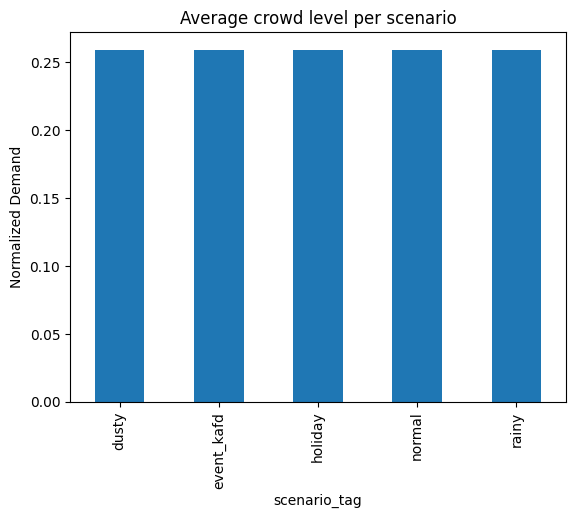

In [34]:
import matplotlib.pyplot as plt
week_df.groupby("scenario_tag")["demand_norm_final"].mean().plot(kind="bar", title="Average crowd level per scenario")
plt.ylabel("Normalized Demand")
plt.show()


In [35]:
import yaml
CONF = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"
with open(CONF) as f:
    config = yaml.safe_load(f)

print("has multipliers:", "multipliers" in config)
print("weather keys:", list(config["multipliers"]["weather"].keys()))
print("event keys:", list(config["multipliers"]["events"].keys()))


has multipliers: True
weather keys: ['Sunny', 'Cloudy', 'Dusty', 'Rainy']
event keys: ['Concert', 'Sports', 'Expo', 'Other', 'CityWideBackground']


In [40]:
import json, csv, os

SEED = "/content/2025_GP_28/masar-sim/data/seeds"

# تحميل ملفات الـ seeds
with open(f"{SEED}/stations.json") as f:
    stations = json.load(f)
with open(f"{SEED}/weather_patterns.json") as f:
    weather = json.load(f)
with open(f"{SEED}/calendar_events.csv") as f:
    events = list(csv.DictReader(f))
with open(f"{SEED}/holidays.csv") as f:
    holidays = list(csv.DictReader(f))

# إنشاء قاموس seeds
seeds = {
    "stations": stations,
    "weather": weather,
    "events": events,
    "holidays": holidays
}


In [41]:
from datetime import datetime
ts = datetime(2025, 9, 23, 9, 0)
print(modifiers.compute_demand_modifier(ts, "KAFD", seeds, config))


{'station': 'KAFD', 'date': '2025-09-23', 'weather': 'Sunny', 'station_scale': 1.0843373493975905, 'weekend_mult': 1.0, 'weather_mult': 1.0, 'event_mult': 1.0, 'holiday_mult': 2.0, 'final_demand_modifier': 2.168674698795181}


In [45]:
import importlib.util
spec = importlib.util.spec_from_file_location("modifiers", "/content/2025_GP_28/masar-sim/lib/modifiers.py")
modifiers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modifiers)


In [47]:
import importlib.util, importlib
mod_path = "/content/2025_GP_28/masar-sim/lib/modifiers.py"
spec = importlib.util.spec_from_file_location("modifiers", mod_path)
modifiers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modifiers)


In [48]:
import yaml, json, csv
from datetime import datetime

# حمّلي نفس الـ seeds والـ config اللي تستخدمينهم في النوتبوك
CONF = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"
with open(CONF) as f:
    config = yaml.safe_load(f)

seed_path = "/content/2025_GP_28/masar-sim/data/seeds"
with open(f"{seed_path}/stations.json") as f:
    stations = json.load(f)
with open(f"{seed_path}/weather_patterns.json") as f:
    weather = json.load(f)
with open(f"{seed_path}/calendar_events.csv") as f:
    events = list(csv.DictReader(f))
with open(f"{seed_path}/holidays.csv") as f:
    holidays = list(csv.DictReader(f))

seeds = {"stations": stations, "weather": weather, "events": events, "holidays": holidays}

ts = datetime(2025, 9, 23, 9, 0)
print(modifiers.compute_demand_modifier(ts, "KAFD", seeds, config))


{'station': 'KAFD', 'date': '2025-09-23', 'weather': 'Sunny', 'station_scale': 1.0843373493975905, 'weekend_mult': 1.0, 'weather_mult': 1.0, 'event_mult': 1.0, 'holiday_mult': 2.0, 'final_demand_modifier': 2.168674698795181}


In [49]:
import importlib.util, importlib
mod_path = "/content/2025_GP_28/masar-sim/lib/modifiers.py"
spec = importlib.util.spec_from_file_location("modifiers", mod_path)
modifiers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modifiers)


In [53]:
import sys, importlib.util, inspect

mod_path = "/content/2025_GP_28/masar-sim/lib/modifiers.py"
# امسحي النسخة الكاشية لو موجودة
if "modifiers" in sys.modules:
    del sys.modules["modifiers"]

spec = importlib.util.spec_from_file_location("modifiers", mod_path)
modifiers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modifiers)

print("✅ Loaded from:", modifiers.__file__)
print("🔎 uses events_map? ->", "events_map" in inspect.getsource(modifiers.compute_demand_modifier))


✅ Loaded from: /content/2025_GP_28/masar-sim/lib/modifiers.py
🔎 uses events_map? -> False


In [54]:
# 1) افحص السورس الحالي للتوثيق
import inspect
print(inspect.getsource(modifiers.compute_demand_modifier))


def compute_demand_modifier(ts, station_key, seeds, config):
    date_str = ts.date().isoformat()
    weekday  = ts.weekday()
    st = _get_station(seeds, station_key)
    station_scale = _station_scale_from_capacity(seeds["stations"], st)

    weekend_mult = float(config["multipliers"]["weekend"]) if weekday in [4,5] else 1.0

    w = seeds["weather"].get(date_str, {"condition":"Sunny"})
    weather_cond = w["condition"] if isinstance(w, dict) else str(w)
    weather_mult = float(config["multipliers"]["weather"].get(weather_cond, 1.0))

    sid = str(st.get("station_id","")).upper()
    scode = str(st.get("code","")).upper()
    event_mult = 1.0
    for ev in seeds["events"]:
        ev_station = str(ev.get("station_id") or ev.get("station") or ev.get("station_code") or "").upper()
        if ev.get("date")==date_str and ev_station in {sid, scode}:
            et = ev.get("event_type","Other")
            event_mult = max(event_mult, float(config["events"].get(et, 1.0)))

    holiday_

In [58]:
# 2) بدّل الدالة بدالة مُصحّحة تستخدم events_map + تدعم CITYWIDE/ALL
from typing import Any, Dict, List

def compute_demand_modifier_patched(ts, station_key, seeds: Dict[str, Any], config: Dict[str, Any]) -> Dict[str, Any]:
    date_str = ts.date().isoformat()
    weekday  = ts.weekday()  # Monday=0 .. Sunday=6

    stations      = seeds.get("stations", [])
    weather_seed  = seeds.get("weather", {}) or {}
    events_seed   = seeds.get("events", [])  or []
    holidays_seed = seeds.get("holidays", []) or []

    multipliers = config.get("multipliers", {}) or {}
    weather_map = multipliers.get("weather", {}) or {}

    # 🔧 أهم نقطة: خذ events من multipliers.events ثم config.events، مع fallback {}
    events_map = (
        (multipliers.get("events") if isinstance(multipliers.get("events"), dict) else {}) or
        (config.get("events")      if isinstance(config.get("events"),      dict) else {}) or
        {}
    )

    # --- helpers من ملفك الحالي ---
    def _match_station(sta: Dict[str, Any], key: Any) -> bool:
        k = str(key).upper()
        return str(sta.get("station_id", "")).upper() == k or str(sta.get("code", "")).upper() == k

    def _get_station(seeds: Dict[str, Any], key: Any) -> Dict[str, Any]:
        for s in seeds.get("stations", []):
            if _match_station(s, key): return s
        raise ValueError(f"Station not found: {key}")

    def _first_number(*vals, default=None):
        for v in vals:
            if isinstance(v, (int,float)): return v
            try: return float(v)
            except Exception: pass
        return default

    def _station_scale_from_capacity(stations: List[Dict[str, Any]], rec: Dict[str, Any]) -> float:
        cand_keys = ["capacity_platform", "peak_capacity", "platform_capacity", "peak_cap"]
        def cap_of(r): return _first_number(*[r.get(k) for k in cand_keys])
        caps = [cap_of(r) for r in stations]
        caps = [c for c in caps if isinstance(c,(int,float))]
        mean_cap = (sum(caps)/len(caps)) if caps else 1500.0
        station_cap = cap_of(rec)
        if not isinstance(station_cap,(int,float)): station_cap = mean_cap
        return (float(station_cap)/float(mean_cap)) if mean_cap>0 else 1.0

    st = _get_station(seeds, station_key)
    station_scale = _station_scale_from_capacity(stations, st)

    # Weekend (Fri=4, Sat=5)
    weekend_base = float(multipliers.get("weekend", 1.0))
    weekend_mult = weekend_base if weekday in [4,5] else 1.0

    # Weather
    w = weather_seed.get(date_str, {"condition":"Sunny"})
    weather_cond = w.get("condition","Sunny") if isinstance(w, dict) else str(w)
    weather_mult = float(weather_map.get(weather_cond, 1.0))

    # Events (station-specific أو citywide)
    sid   = str(st.get("station_id","")).upper()
    scode = str(st.get("code","")).upper()

    event_mult = 1.0
    for ev in events_seed:
        ev_station_raw = str(ev.get("station_id") or ev.get("station") or ev.get("station_code") or "").strip().upper()
        is_citywide = ev_station_raw in {"", "ALL", "CITY", "CITYWIDE"}
        if ev.get("date")==date_str and (is_citywide or ev_station_raw in {sid, scode}):
            et = ev.get("event_type","Other")
            event_mult = max(event_mult, float(events_map.get(et, 1.0)))

    # Holiday
    holiday_mult = float(multipliers.get("holiday", 1.0))
    for hol in holidays_seed:
        if hol.get("date")==date_str:
            try: holiday_mult = float(hol.get("demand_modifier", holiday_mult))
            except: pass

    final = station_scale * weekend_mult * weather_mult * event_mult * holiday_mult
    return {
        "station": scode or sid,
        "date": date_str,
        "weather": weather_cond,
        "station_scale": station_scale,
        "weekend_mult": weekend_mult,
        "weather_mult": weather_mult,
        "event_mult": event_mult,
        "holiday_mult": holiday_mult,
        "final_demand_modifier": final,
    }

# اربط الباتش مكان الدالة
modifiers.compute_demand_modifier = compute_demand_modifier_patched

import inspect
print("✅ patched. uses events_map? ->", "events_map" in inspect.getsource(modifiers.compute_demand_modifier))


✅ patched. uses events_map? -> True


In [59]:
from datetime import datetime
ts = datetime(2025, 9, 23, 9, 0)
print(modifiers.compute_demand_modifier(ts, "KAFD", seeds, config))


{'station': 'KAFD', 'date': '2025-09-23', 'weather': 'Sunny', 'station_scale': 1.0843373493975905, 'weekend_mult': 1.0, 'weather_mult': 1.0, 'event_mult': 1.1, 'holiday_mult': 2.0, 'final_demand_modifier': 2.385542168674699}


In [61]:
import importlib.util, types, inspect

# حمّل ملف modifiers.py من الريبو
mod_path = "/content/2025_GP_28/masar-sim/lib/modifiers.py"
spec = importlib.util.spec_from_file_location("modifiers", mod_path)
modifiers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(modifiers)

def compute_demand_modifier_patched(ts, station_key, seeds, config):
    """نسخة آمنة تتسامح مع غياب events وتدعم CityWide/ALL."""
    from datetime import datetime
    def _first_number(*vals, default=None):
        for v in vals:
            if isinstance(v, (int,float)): return v
            try:
                return float(v)
            except Exception:
                pass
        return default

    date_str = ts.date().isoformat()
    weekday  = ts.weekday()

    stations      = seeds.get("stations", []) or []
    weather_seed  = seeds.get("weather", {})   or {}
    events_seed   = seeds.get("events", [])    or []
    holidays_seed = seeds.get("holidays", [])  or []

    multipliers = config.get("multipliers", {}) or {}
    weather_map = multipliers.get("weather", {}) or {}
    # 👇 آمن: نبحث عن events سواء في الجذر أو تحت multipliers
    events_map  = (config.get("events") or multipliers.get("events") or {})

    # محطة + scale
    def _match_station(sta, key):
        k = str(key).upper()
        return str(sta.get("station_id","")).upper()==k or str(sta.get("code","")).upper()==k

    st = None
    for s in stations:
        if _match_station(s, station_key):
            st = s; break
    if st is None:
        raise ValueError(f"Station not found: {station_key}")

    cand_keys = ["capacity_platform","peak_capacity","platform_capacity","peak_cap"]
    def cap_of(r): return _first_number(*[r.get(k) for k in cand_keys])
    caps = [cap_of(r) for r in stations]
    caps = [c for c in caps if isinstance(c,(int,float))]
    mean_cap = (sum(caps)/len(caps)) if caps else 1500.0
    station_cap = cap_of(st)
    if not isinstance(station_cap,(int,float)): station_cap = mean_cap
    station_scale = (float(station_cap)/float(mean_cap)) if mean_cap>0 else 1.0

    # Weekend Fri=4, Sat=5
    weekend_mult = float(multipliers.get("weekend", 1.0)) if weekday in [4,5] else 1.0

    # Weather
    w = weather_seed.get(date_str, {"condition":"Sunny"})
    weather_cond = w.get("condition","Sunny") if isinstance(w,dict) else str(w)
    weather_mult = float(weather_map.get(weather_cond, 1.0))

    # Events (محطة محددة أو CityWide/ALL)
    sid   = str(st.get("station_id","")).upper()
    scode = str(st.get("code","")).upper()
    event_mult = 1.0
    for ev in events_seed:
        ev_station_raw = str(ev.get("station_id") or ev.get("station") or ev.get("station_code") or "").strip().upper()
        is_citywide = ev_station_raw in {"", "ALL", "CITY", "CITYWIDE"}
        if ev.get("date")==date_str and (is_citywide or ev_station_raw in {sid, scode}):
            et = ev.get("event_type","Other")
            event_mult = max(event_mult, float(events_map.get(et, 1.0)))

    # Holiday
    holiday_mult = float(multipliers.get("holiday", 1.0))
    for hol in holidays_seed:
        if hol.get("date")==date_str:
            try:
                holiday_mult = float(hol.get("demand_modifier", holiday_mult))
            except Exception:
                pass

    final = station_scale * weekend_mult * weather_mult * event_mult * holiday_mult
    return {
        "station": scode or sid,
        "date": date_str,
        "weather": weather_cond,
        "station_scale": station_scale,
        "weekend_mult": weekend_mult,
        "weather_mult": weather_mult,
        "event_mult": event_mult,
        "holiday_mult": holiday_mult,
        "final_demand_modifier": final,
    }

# اربطي الباتش مكان الدالة الأصلية
modifiers.compute_demand_modifier = compute_demand_modifier_patched

import inspect
print("✅ patched & safe. uses flexible events_map ->",
      any(k in inspect.getsource(modifiers.compute_demand_modifier) for k in ["events_map","multipliers.get(\"events\")"]))


✅ patched & safe. uses flexible events_map -> True


In [63]:
import yaml, json, csv
from datetime import datetime

CONF = "/content/2025_GP_28/masar-sim/sims/00_config.yaml"
with open(CONF) as f:
    config = yaml.safe_load(f)

seed_path = "/content/2025_GP_28/masar-sim/data/seeds"
with open(f"{seed_path}/stations.json") as f:
    stations = json.load(f)
with open(f"{seed_path}/weather_patterns.json") as f:
    weather = json.load(f)
with open(f"{seed_path}/calendar_events.csv") as f:
    events = list(csv.DictReader(f))
with open(f"{seed_path}/holidays.csv") as f:
    holidays = list(csv.DictReader(f))

# نحطهم داخل dict موحد
seeds = {
    "stations": stations,
    "weather": weather,
    "events": events,
    "holidays": holidays
}

print("✅ seeds & config loaded successfully")


✅ seeds & config loaded successfully


In [66]:
frames = []
for day_info in days:
    day_date = day_info["date"]
    tag      = day_info["tag"]

    w_over, h_over, e_over = build_overrides_for_date(day_date, tag)
    day_df = generate_day_df(day_date, w_over, h_over, e_over)
    day_df["scenario_tag"] = tag
    day_df["date"] = day_date.isoformat()
    frames.append(day_df)

week_df = pd.concat(frames, ignore_index=True)
out_week = f"{GEN}/occupancy_week.csv"
os.makedirs(GEN, exist_ok=True)
week_df.to_csv(out_week, index=False)
print("✅ Saved ->", out_week, " rows=", len(week_df))


KeyError: 'events'

In [ ]:
import pandas as pd

out_week = f"{GEN}/occupancy_week.csv"
week_df = pd.read_csv(out_week, parse_dates=["timestamp"])

print("days=", week_df["timestamp"].dt.date.nunique(),
      "stations=", week_df["station_id"].nunique(),
      "rows=", len(week_df))

print("\nby scenario:")
print(week_df["scenario_tag"].value_counts())

print("\nany > capacity ?",
      (week_df["cabin_passenger_count"] > week_df["cabin_capacity"]).any())


In [ ]:
print(week_df.groupby("scenario_tag")["demand_norm_final"].mean().round(4))


In [ ]:
from google.colab import files
files.download(out_week)
